In [ ]:
import torch
import numpy as np
import json
from transformers import AutoTokenizer
import networkx as nx
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import hierarchical as hrc

device = torch.device("cuda:0")
MODEL_NAME = "google/gemma-2b"
g, _, _ = hrc.get_g(MODEL_NAME, device)
vocab_dict, vocab_list = hrc.get_vocab(MODEL_NAME)

In [2]:
cats, G, sorted_keys = hrc.get_categories('noun', 'gemma')

In [3]:
torch.manual_seed(100)
shuffled_g = g[torch.randperm(g.shape[0])]
alpha = 0.7

vec_reps = {'original': {'split': {}, 'non_split': {}}, 'shuffled': {'split': {}, 'non_split': {}},
            'train_lemmas': {}, 'test_lemmas': {}, 'g': g, 'shuffled_g': shuffled_g, 'alpha': alpha}

for node in tqdm(sorted_keys):
    lemmas = cats[node]
    original_dir = hrc.estimate_cat_dir(lemmas, g, vocab_dict)
    shuffled_dir = hrc.estimate_cat_dir(lemmas, shuffled_g, vocab_dict)

    vec_reps['original']['non_split'].update({node: original_dir})
    vec_reps['shuffled']['non_split'].update({node: shuffled_dir})
    
    random.seed(100)
    random.shuffle(lemmas)

    train_lemmas = lemmas[:int(alpha * len(lemmas))]
    test_lemmas = lemmas[int(alpha * len(lemmas)):]
    original_dir = hrc.estimate_cat_dir(train_lemmas, g, vocab_dict)
    shuffled_dir = hrc.estimate_cat_dir(train_lemmas, shuffled_g, vocab_dict)

    vec_reps['original']['split'].update({node: original_dir})
    vec_reps['shuffled']['split'].update({node: shuffled_dir})
    vec_reps['train_lemmas'].update({node: train_lemmas})
    vec_reps['test_lemmas'].update({node: test_lemmas})

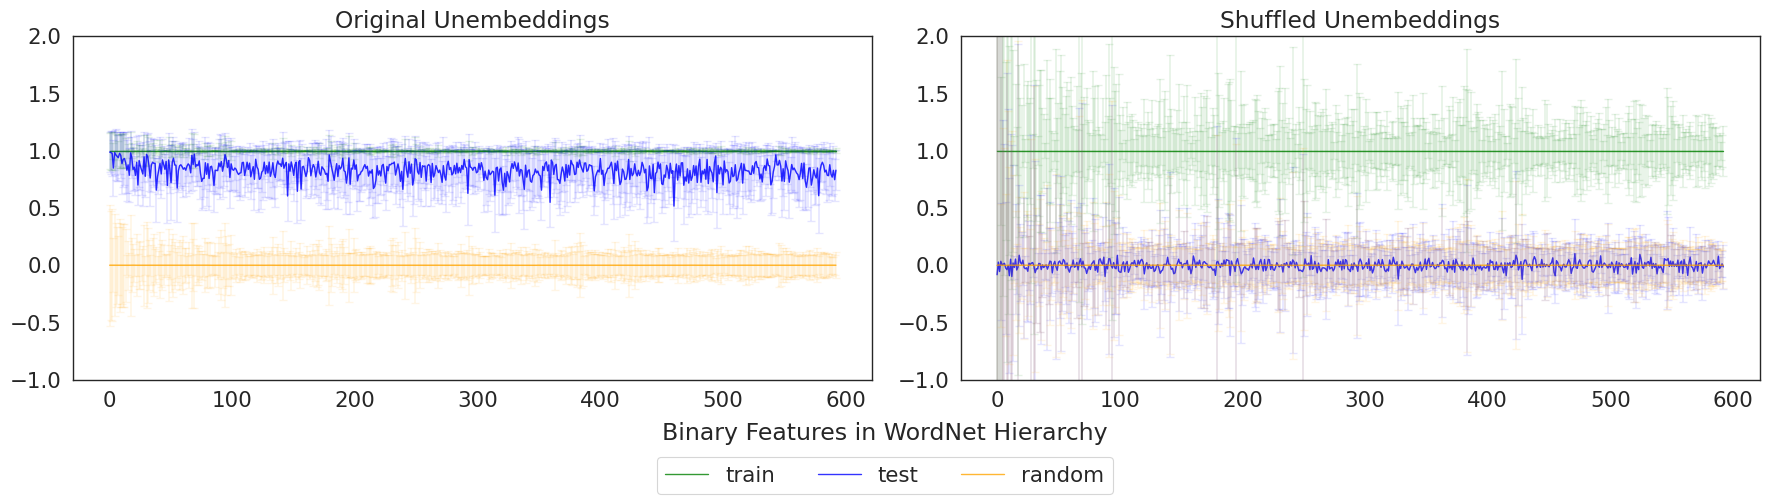

In [4]:
hrc.show_evaluation(vec_reps, sorted_keys, vocab_dict, version='lda', save_to='figures/eval_lda_noun_gemma.pdf')

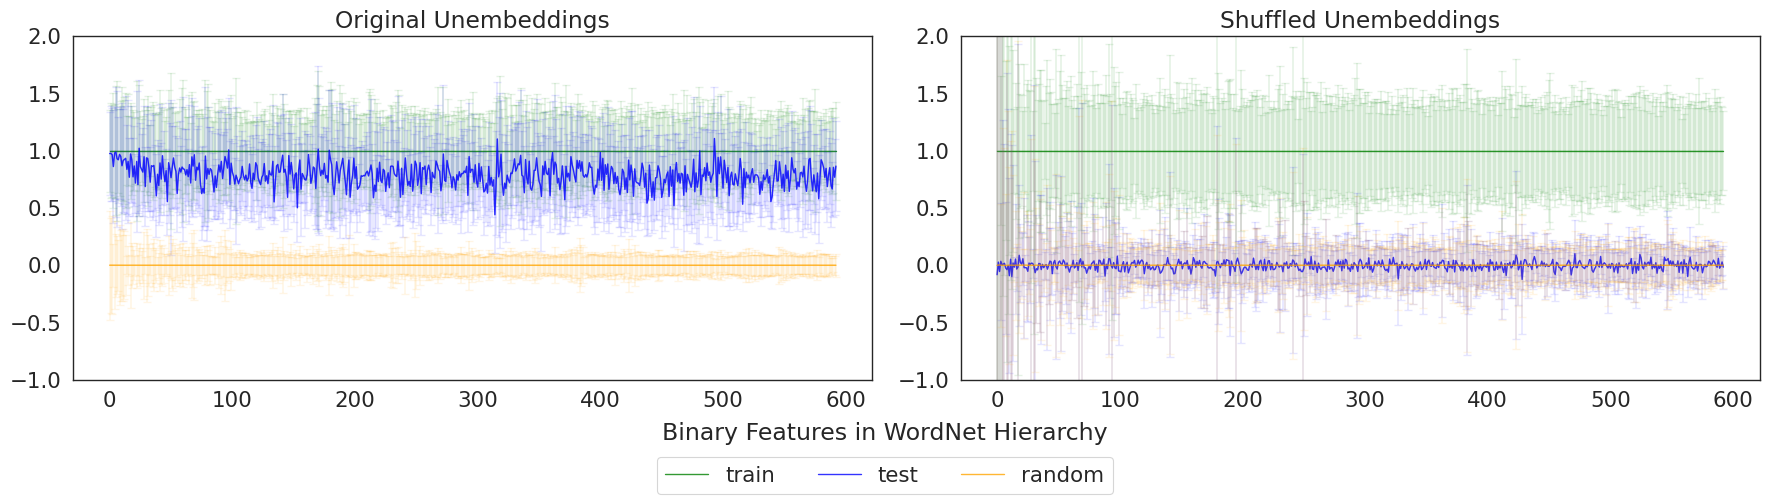

In [5]:
hrc.show_evaluation(vec_reps, sorted_keys, vocab_dict, version='mean', save_to='figures/eval_mean_noun_gemma.pdf')

In [6]:
def plot_heatmaps(vec_reps, dist_matrix, version = 'lda'):
    original_dirs = torch.stack([v[version] for k, v in vec_reps['original']['non_split'].items()])
    original_dirs  = original_dirs  / original_dirs .norm(dim = 1).unsqueeze(1)
    shuffled_dirs = torch.stack([v[version] for k, v in vec_reps['shuffled']['non_split'].items()])
    shuffled_dirs = shuffled_dirs / shuffled_dirs.norm(dim = 1).unsqueeze(1)

    mats = [dist_matrix,
        (original_dirs @ original_dirs.T).cpu().numpy(),
        (shuffled_dirs @ shuffled_dirs.T).cpu().numpy()]

    titles = ["Pairwise Shortest Distance",
            rf'$\cos(\bar{{\ell}}_{{w}}, \bar{{\ell}}_{{z}})$ (Original Unembeddings)',
            rf'$\cos(\bar{{\ell}}_{{w}}, \bar{{\ell}}_{{z}})$ (Shuffled Unembeddings)',]
    
    hrc.cos_heatmap(mats, titles, figsize = (19, 6),
                    use_absvals=False, cmap = 'seismic',
                    save_to = "figures/heatmap_noun_gemma.pdf")

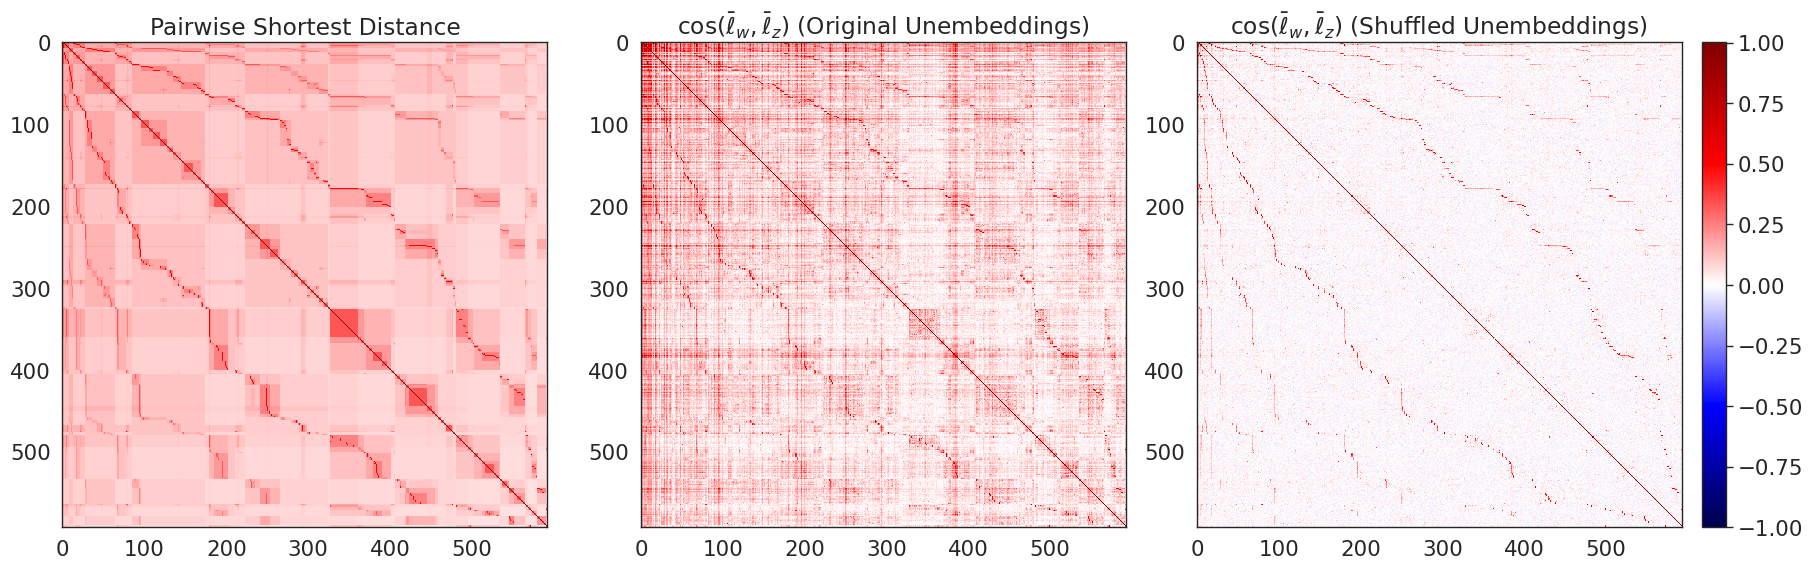

In [7]:
G_undirected = G.to_undirected()
dist_matrix = nx.floyd_warshall_numpy(G_undirected, nodelist=sorted_keys)
dist_matrix = 1 / (dist_matrix+1)
plot_heatmaps(vec_reps, dist_matrix, version = 'lda')

In [8]:
reptile_ind = [i for i, s in enumerate(sorted_keys) if "reptile" in s]
mammal_ind = [i for i, s in enumerate(sorted_keys) if "mammal" in s]

original_dirs = torch.stack([v['lda'] for k, v in vec_reps['original']['non_split'].items()])
original_dirs  = original_dirs  / original_dirs .norm(dim = 1).unsqueeze(1)
shuffled_dirs = torch.stack([v['lda'] for k, v in vec_reps['shuffled']['non_split'].items()])
shuffled_dirs = shuffled_dirs / shuffled_dirs.norm(dim = 1).unsqueeze(1)

original_cos = (original_dirs @ original_dirs.T).cpu().numpy()
shuffled_cos = (shuffled_dirs @ shuffled_dirs.T).cpu().numpy()

print([1/dist_matrix[reptile_ind, mammal_ind].item()-1,
    original_cos[reptile_ind, mammal_ind].item(),
    shuffled_cos[reptile_ind, mammal_ind].item()])

[2.0, 0.19847941398620605, 0.03082432970404625]


In [9]:
version = 'lda'
cosines = {i: {j : {k: {'parent': [], 'random_parent': []}
            for k in ['split', 'non_split']}
            for j in ['original', 'shuffled']}
            for i in ['b', 'e']}

random.seed(100)
for node in sorted_keys:
    if len(list(G.predecessors(node))) > 0:
        parent = list(G.predecessors(node))[0]
        for j in ['original', 'shuffled']:
            for k in ['split', 'non_split']:
                child_dir = vec_reps[j][k][node][version]
                parent_dir = vec_reps[j][k][parent][version]
                child_parent = child_dir - parent_dir
                child_parent = child_parent / child_parent.norm()
                parent_dir = parent_dir / parent_dir.norm()
                cosines['b'][j][k]['parent'].append((child_parent @ parent_dir).cpu().numpy())
                
                
                random_parent = sorted_keys[random.randint(0, len(sorted_keys)-1)]
                parent_dir = vec_reps[j][k][random_parent][version]
                child_parent = child_dir - parent_dir
                child_parent = child_parent / child_parent.norm()
                parent_dir = parent_dir / parent_dir.norm()
                cosines['b'][j][k]['random_parent'].append((child_parent @ parent_dir).cpu().numpy())
        if len(list(G.predecessors(parent))) > 0:
            grandparent = list(G.predecessors(parent))[0]
            for j in ['original', 'shuffled']:
                for k in ['split', 'non_split']:
                    child_dir = vec_reps[j][k][node][version]
                    parent_dir = vec_reps[j][k][parent][version]
                    grandparent_dir = vec_reps[j][k][grandparent][version]
                    child_parent = child_dir - parent_dir
                    parent_grandparent = parent_dir - grandparent_dir
                    child_parent = child_parent / child_parent.norm()
                    parent_grandparent = parent_grandparent / parent_grandparent.norm()
                    cosines['e'][j][k]['parent'].append((child_parent @ parent_grandparent).cpu().numpy())

                    random_parent = sorted_keys[random.randint(0, len(sorted_keys)-1)]
                    parent_dir = vec_reps[j][k][random_parent][version]
                    random_grandparent = sorted_keys[random.randint(0, len(sorted_keys)-1)]
                    grandparent_dir = vec_reps[j][k][random_grandparent][version]
                    child_parent = child_dir - parent_dir
                    parent_grandparent = parent_dir - grandparent_dir
                    child_parent = child_parent / child_parent.norm()
                    parent_grandparent = parent_grandparent / parent_grandparent.norm()
                    cosines['e'][j][k]['random_parent'].append((child_parent @ parent_grandparent).cpu().numpy())

In [10]:
colors = {'original': {'parent': 'blue', 'random_parent': 'orange'}, 'shuffled': {'parent': 'green', 'random_parent': 'pink'}}
markers = {'parent': 'o', 'random_parent': 'x'}
title_b = rf'$\cos(\bar{{\ell}}_{{w}} - \bar{{\ell}}_{{parent \,\, of \,\, w}},\bar{{\ell}}_{{parent \,\, of \,\, w}})$'
title_e = rf'$\cos(\bar{{\ell}}_{{w}} - \bar{{\ell}}_{{parent \,\, of \,\, w}},\bar{{\ell}}_{{parent \,\, of \,\, w}} -\bar{{\ell}}_{{grandparent \,\, of \,\, w}})$'
titles = {'b': {'split': title_b + ', Training set', 'non_split': title_b + ', Whole set'},
            'e': {'split': title_e + ', Training set', 'non_split': title_e + ', Whole set'}}
label_arr = {'original':{ 'parent': 'Original Unembeddings', 'random_parent': 'Original Unembeddings + Random Parent'},
            'shuffled': {'parent': 'Shuffled Unembeddings', 'random_parent': 'Shuffled Unembeddings + Random Parent'}}

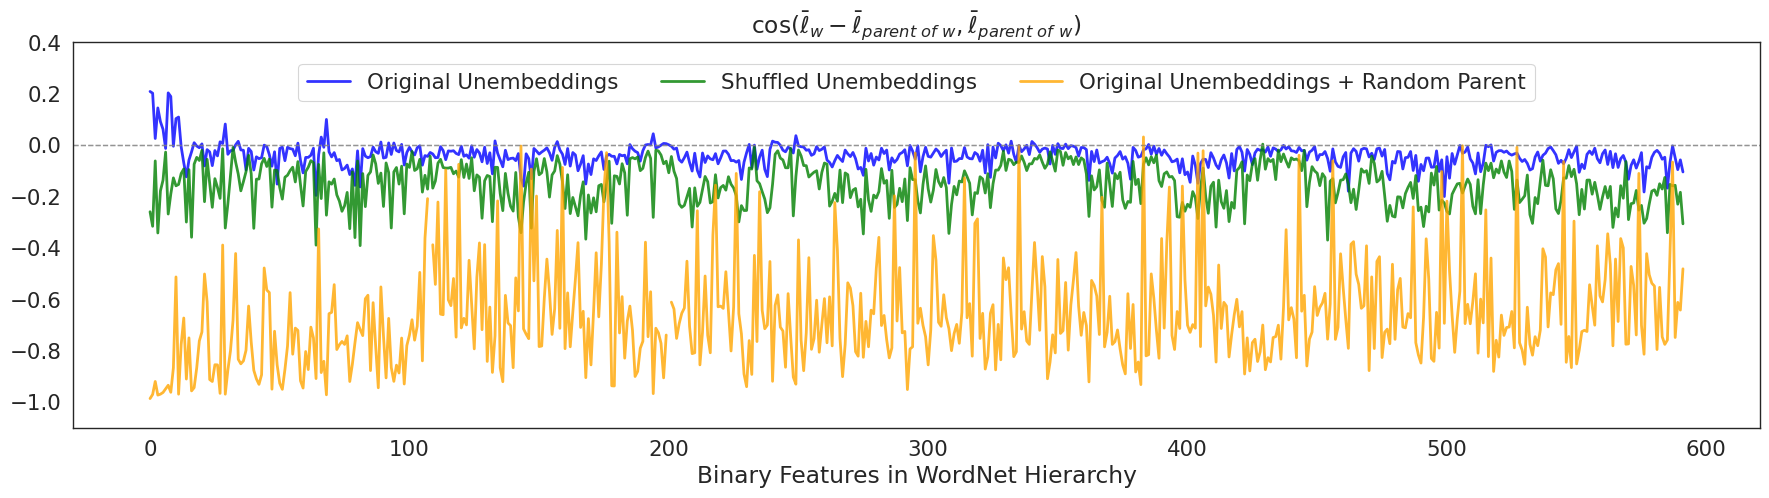

In [11]:
fig = plt.subplots(1, 1, figsize = (18, 5))
i = 'b'
for j in ['split']:
    for l in ['parent', 'random_parent']:
        for k in ['original', 'shuffled']:
            if l == 'random_parent' and k == 'shuffled':
                continue
            inds = range(len(cosines[i][k][j][l]))
            plt.plot(inds, cosines[i][k][j][l], alpha = 0.8, color = colors[k][l], linewidth=2, label = label_arr[k][l])
        plt.axhline(y=0, color='grey', linestyle='--', alpha = 0.6, linewidth=1)
        plt.title(title_b)
        plt.ylim(-1.1,0.4)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 0.82), ncol=3)
plt.tight_layout()
plt.xlabel(rf'Binary Features in WordNet Hierarchy')
save_to = "figures/hier_ortho_b_noun_gemma_main.pdf"
if save_to is not None:
    plt.savefig(save_to, bbox_inches='tight')
plt.show()

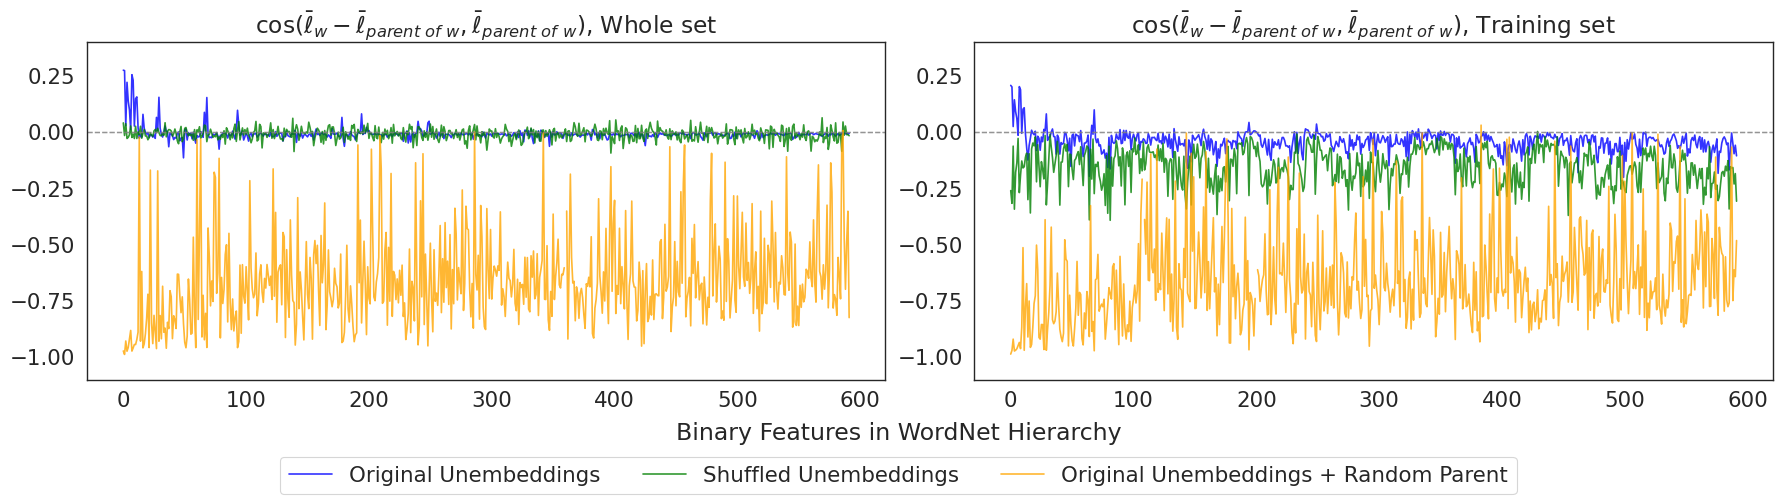

In [12]:
fig, ax = plt.subplots(1, 2, figsize = (18, 5))
ax = ax.flatten()
count = 0
i = 'b'
for j in ['non_split', 'split']:
    for l in ['parent', 'random_parent']:
        for k in ['original', 'shuffled']:
            if l == 'random_parent' and k == 'shuffled':
                continue
            inds = range(len(cosines[i][k][j][l]))
            # ax[count].scatter(inds, cosines[i][k][j][l], alpha = 0.8, color = colors[k][l], s = 5, marker = markers[l], label = label_arr[k][l])
            ax[count].plot(inds, cosines[i][k][j][l], alpha = 0.8, color = colors[k][l], label = label_arr[k][l])
        ax[count].axhline(y=0, color='grey', linestyle='--', alpha = 0.6, linewidth=1)
        ax[count].set_title(titles[i][j])
        ax[count].set_ylim(-1.1,0.4)
        # ax[count].set_xticks([])
    count += 1
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.04), ncol=3)
fig.supxlabel(rf'Binary Features in WordNet Hierarchy',x=0.5, y=0.08, fontsize=17)
plt.tight_layout()
save_to = "figures/hier_ortho_b_noun_gemma.pdf"
if save_to is not None:
    plt.savefig(save_to, bbox_inches='tight')
plt.show()

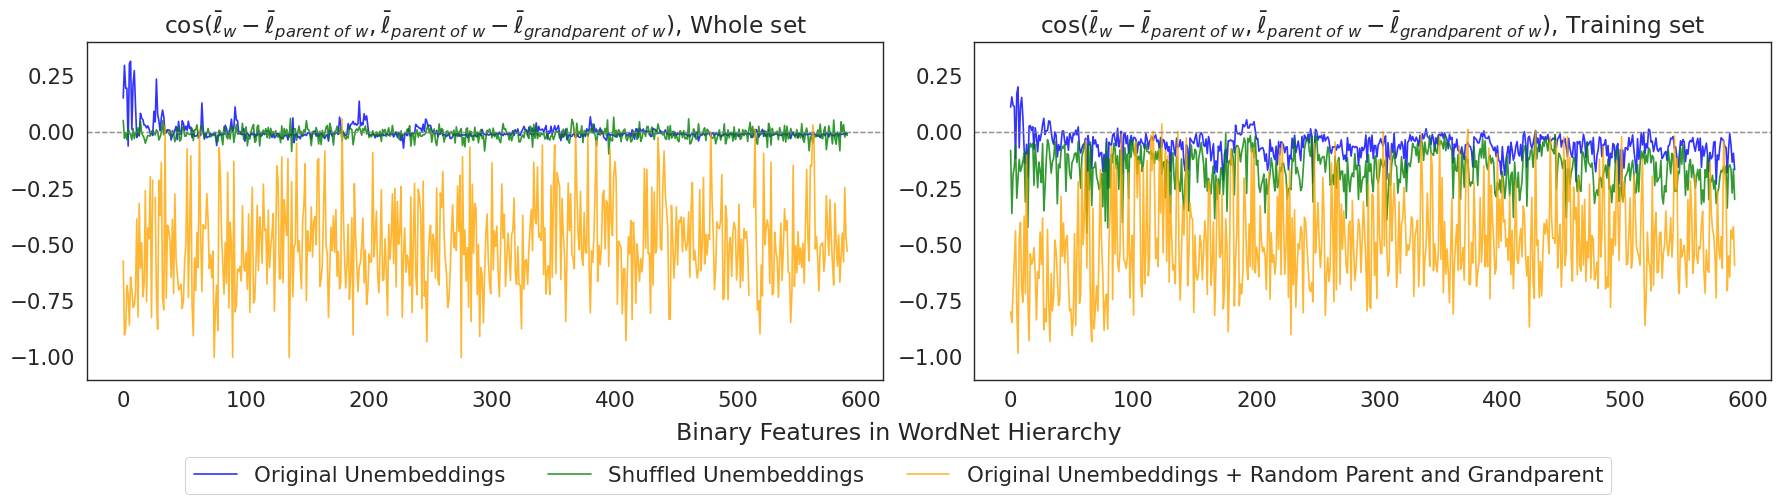

In [13]:
label_arr = {'original':{ 'parent': 'Original Unembeddings', 'random_parent': 'Original Unembeddings + Random Parent and Grandparent'},
            'shuffled': {'parent': 'Shuffled Unembeddings', 'random_parent': 'Shuffled Unembeddings + Random Parent'}}
fig, ax = plt.subplots(1, 2, figsize = (18, 5))
ax = ax.flatten()
count = 0
i = 'e'
for j in ['non_split', 'split']:
    for l in ['parent', 'random_parent']:
        for k in ['original', 'shuffled']:
            if l == 'random_parent' and k == 'shuffled':
                continue
            inds = range(len(cosines[i][k][j][l]))
            # ax[count].scatter(inds, cosines[i][k][j][l], alpha = 0.8, color = colors[k][l], s = 5, marker = markers[l], label = label_arr[k][l])
            ax[count].plot(inds, cosines[i][k][j][l], alpha = 0.8, color = colors[k][l], label = label_arr[k][l])
        ax[count].axhline(y=0, color='grey', linestyle='--', alpha = 0.6, linewidth=1)
        ax[count].set_title(titles[i][j])
        ax[count].set_ylim(-1.1,0.4)
        # ax[count].set_xticks([])
    count += 1
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.04), ncol=3)
fig.supxlabel(rf'Binary Features in WordNet Hierarchy',x=0.5, y=0.08, fontsize=17)
plt.tight_layout()
save_to = "figures/hier_ortho_e_noun_gemma.pdf"
if save_to is not None:
    plt.savefig(save_to, bbox_inches='tight')
plt.show()